<a href="https://colab.research.google.com/github/CallMeGuptaji/lamacolab/blob/main/export_LaMa_to_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Export LaMa inpainting model to ONNX


Author: [Nikita Selin](https://github.com/OPHoperHPO), [Carve.Photos Team](https://carve.photos) \
HuggingFace Repository with ONNX Model: [Link](https://huggingface.co/Carve/LaMa-ONNX) \
Original repository: [Link](https://github.com/advimman/lama)




## install deps

In [1]:
!git clone https://github.com/Carve-Photos/lama --depth 1

Cloning into 'lama'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 249 (delta 52), reused 114 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 5.68 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
%cd lama

/content/lama


In [ ]:
!cd ..

In [3]:
!ls

bin	       export_LaMa_to_onnx.ipynb  models
conda_env.yml  fetch_data		  README.md
configs        LaMa_inpainting.ipynb	  requirements.txt
docker	       LICENSE			  saicinpainting


In [4]:
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1357  100  1357    0     0  10426      0 --:--:-- --:--:-- --:--:-- 10438
100  363M  100  363M    0     0   254M      0  0:00:01  0:00:01 --:--:--  316M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [1]:
!pip3 install omegaconf webdataset pytorch_lightning pytorch_lightning kornia==0.5.0 onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.5/271.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


In [2]:
!pip install albumentations==0.4.3 numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.3-py3-none-any.whl size=60756 sha256=4f21e2574025b371b58f4b9300f23090d6690249914f670e5376d8c1f152b7b5
  Stored in directory: /root/.cache/pip/wheels/da/20/3b/170da2caa01920545393419c1491141952696af4a14f1b8617
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654003 sha256=df0b70f754710572fdc47b55782153b70f52d05838f38cf7d1d530cd9445f46f
  Stored in directory: /root/.cache/pip/wheels/71/fe/fb/aedb5d6154f27ef4c03e9da7615f0f897885a295949fecf893
Successfully built albumentations imgaug
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


## init model

In [ ]:
import torch
from omegaconf import OmegaConf
from yaml import safe_load

from saicinpainting.training.trainers.default import (
    DefaultInpaintingTrainingModule,
)


class ExportLama(torch.nn.Module):
    def forward(self, image: torch.Tensor, mask: torch.Tensor):
        masked_img = image * (1 - mask)

        if self.model.concat_mask:
            masked_img = torch.cat([masked_img, mask], dim=1)

        predicted_image = self.model.generator(masked_img)
        inpainted = mask * predicted_image + (1 - mask) * image
        return torch.clamp(inpainted * 255, min=0, max=255)

Detectron v2 is not installed


## export onnx

In [ ]:
# Load the configuration file
config = OmegaConf.create(safe_load(open("/content/lama/big-lama/config.yaml")))

# Extract and modify training model configuration
kwargs = dict(config.training_model)
kwargs.pop("kind")
kwargs["use_ddp"] = True

# Load the model state
state = torch.load("/content/lama/big-lama/models/best.ckpt", map_location="cpu", weights_only=False)
lama_dilated_model = DefaultInpaintingTrainingModule(config, **kwargs)
lama_dilated_model.load_state_dict(state["state_dict"], strict=False)
lama_dilated_model.on_load_checkpoint(state)
lama_dilated_model.freeze()
lama_dilated_model.eval()

# Export the model
exported_model = ExportLama()
exported_model.register_module("model", lama_dilated_model)
exported_model.eval()
exported_model.to("cpu")

# Export to ONNX format
torch.onnx.export(
    exported_model,
    (
        torch.rand(1, 3, 512, 512).type(torch.float32).to("cpu"),
        torch.rand(1, 1, 512, 512).type(torch.float32).to("cpu")
    ),
    "/content/lama_fp32.onnx",
    input_names=["image", "mask"],
    output_names=["output"],
    export_params=True,
    do_constant_folding=True,
    opset_version=17,
    verbose=False,
)

print("Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)")


/tmp/ipython-input-2070210435.py:30: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)


## Test exported onnx model

In [ ]:
import cv2
import numpy as np
import onnxruntime
import torch
import io
import requests
from PIL import Image

def get_image(image):
    if isinstance(image, Image.Image):
        img = np.array(image)
    elif isinstance(image, np.ndarray):
        img = image.copy()
    else:
        raise Exception("Input image should be either PIL Image or numpy array!")

    if img.ndim == 3:
        img = np.transpose(img, (2, 0, 1))  # chw
    elif img.ndim == 2:
        img = img[np.newaxis, ...]

    assert img.ndim == 3

    img = img.astype(np.float32) / 255
    return img


def ceil_modulo(x, mod):
    if x % mod == 0:
        return x
    return (x // mod + 1) * mod


def scale_image(img, factor, interpolation=cv2.INTER_AREA):
    if img.shape[0] == 1:
        img = img[0]
    else:
        img = np.transpose(img, (1, 2, 0))

    img = cv2.resize(img, dsize=None, fx=factor, fy=factor, interpolation=interpolation)

    if img.ndim == 2:
        img = img[None, ...]
    else:
        img = np.transpose(img, (2, 0, 1))
    return img


def pad_img_to_modulo(img, mod):
    channels, height, width = img.shape
    out_height = ceil_modulo(height, mod)
    out_width = ceil_modulo(width, mod)
    return np.pad(
        img,
        ((0, 0), (0, out_height - height), (0, out_width - width)),
        mode="symmetric",
    )


def prepare_img_and_mask(image, mask, device, pad_out_to_modulo=8, scale_factor=None):
    out_image = get_image(image)
    out_mask = get_image(mask)

    if scale_factor is not None:
        out_image = scale_image(out_image, scale_factor)
        out_mask = scale_image(out_mask, scale_factor, interpolation=cv2.INTER_NEAREST)

    if pad_out_to_modulo is not None and pad_out_to_modulo > 1:
        out_image = pad_img_to_modulo(out_image, pad_out_to_modulo)
        out_mask = pad_img_to_modulo(out_mask, pad_out_to_modulo)

    out_image = torch.from_numpy(out_image).unsqueeze(0).to(device)
    out_mask = torch.from_numpy(out_mask).unsqueeze(0).to(device)

    out_mask = (out_mask > 0) * 1

    return out_image, out_mask

def open_image(image):
    if isinstance(image, str):
      if image.startswith("http://") or image.startswith("https://"):
        image = Image.open(io.BytesIO(requests.get(image).content))
      else:
        image = Image.open(image)
    return image





In [ ]:
sess_options = onnxruntime.SessionOptions()
model = onnxruntime.InferenceSession('/content/lama_fp32.onnx', sess_options=sess_options)


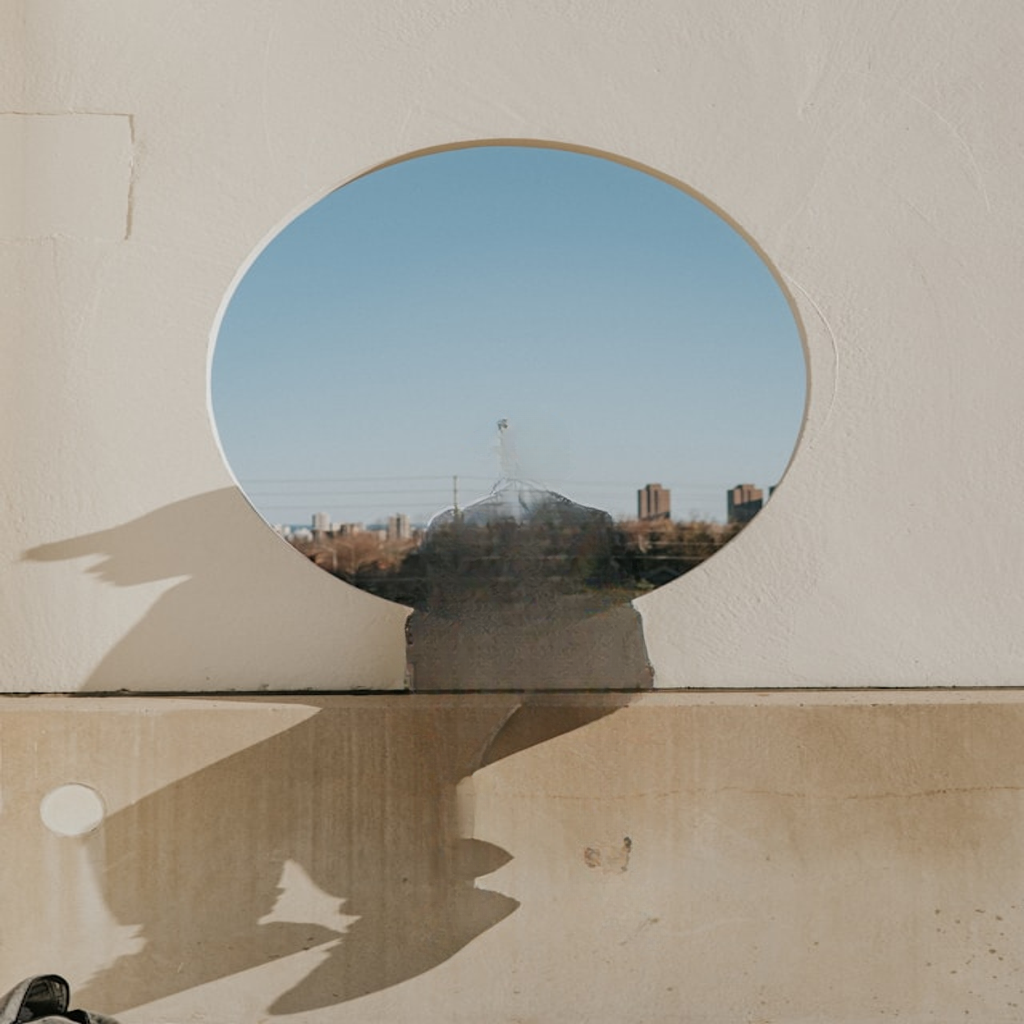

In [ ]:
#@title predict with onnx model
image_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/image.jpg" # @param {type:"string"}
mask_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/mask.png" # @param {type:"string"}

image = open_image(image_url).resize((1024, 1024))
mask = open_image(mask_url).convert("L").resize((1024, 1024))

image, mask = prepare_img_and_mask(image, mask, 'cpu')
# Run the model
outputs = model.run(None,
                    {'image': image.numpy().astype(np.float32),
                     'mask': mask.numpy().astype(np.float32)})

output = outputs[0][0]
# Postprocess the outputs
output = output.transpose(1, 2, 0)
output = output.astype(np.uint8)
output = Image.fromarray(output)
output